# Regression

Prediction of continuous values 

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [25]:
(train_data, train_targets), (test_data, test_targets) = tf.keras.datasets.boston_housing.load_data()

In [26]:
print(f"Train Shape: {train_data.shape}")
print(f"Test Shape: {test_data.shape}")
print(f"Train targets of {len(train_targets)}:\n {train_targets}")

Train Shape: (404, 13)
Test Shape: (102, 13)
Train targets of 404:
 [15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20

## Data preparation

In [27]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /- std
test_data -= mean
test_data /= std

In [28]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### K-fold validation

splitting into K subsets and train on K-1 to validate on the remaining

In [29]:
def k_fold_train(k=4, num_epochs=100):

    num_val_samples = len(train_data) // k
    print(f"number of samples in each set will be {num_val_samples} out of {len(train_data)} overall")

    all_scores = []
    all_mae_histories = []
    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = train_data[i * num_val_samples: (i + 1) *  num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) *  num_val_samples]
        partial_train_data = np.concatenate(
            [train_data[:i *  num_val_samples],
            train_data[(i+1) * num_val_samples:]],
            axis=0
        )
        partial_train_targets = np.concatenate(
            [train_targets[:i *  num_val_samples],
            train_targets[(i+1) * num_val_samples:]],
            axis=0
        )
        model = build_model()
        history = model.fit(
            partial_train_data,
            partial_train_targets,
            epochs=num_epochs,
            batch_size=16,
            verbose=2
        )
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=2)
        print(f"val_mse={val_mse}, val_mae={val_mae}")
        all_scores.append(val_mae)
        all_mae_histories.append(history.history["mae"])
    print(f"All Scores =\n{all_scores}")
    print(f"Mean of All Scores = {np.mean(all_scores)}")

    return all_scores, all_mae_histories

In [30]:
def plot_training(average_mae_history, truncated_mae_history):
    with plt.style.context('seaborn-v0_8'):
            
        # Create a figure and a grid of subplots
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        # Plotting training and validation loss on the first subplot
        ax[0].plot(range(1, len(average_mae_history) + 1), average_mae_history)
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Validation MAE")
        ax[0].legend()
        ax[0].grid(True)
        ax[0].minorticks_on()
        ax[0].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

        # Plotting training and validation accuracy on the second subplot
        ax[1].plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Validation MAE")
        ax[1].legend()
        ax[1].grid(True)
        ax[1].minorticks_on()
        ax[1].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

        # Setting the title for the entire figure
        plt.suptitle("K-fold", fontsize=16)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # padding around subplots.
        plt.show()

number of samples in each set will be 101 out of 404 overall
Processing fold #0
Epoch 1/100


19/19 - 1s - 73ms/step - loss: 191.7976 - mae: 10.4126
Epoch 2/100
19/19 - 0s - 3ms/step - loss: 114.2850 - mae: 7.7063
Epoch 3/100
19/19 - 0s - 8ms/step - loss: 84.6916 - mae: 6.6397
Epoch 4/100
19/19 - 0s - 3ms/step - loss: 73.5565 - mae: 6.1851
Epoch 5/100
19/19 - 0s - 2ms/step - loss: 65.4720 - mae: 5.7183
Epoch 6/100
19/19 - 0s - 3ms/step - loss: 64.3819 - mae: 5.6547
Epoch 7/100
19/19 - 0s - 3ms/step - loss: 64.1045 - mae: 5.7075
Epoch 8/100
19/19 - 0s - 3ms/step - loss: 54.6833 - mae: 5.3320
Epoch 9/100
19/19 - 0s - 2ms/step - loss: 52.2634 - mae: 5.1768
Epoch 10/100
19/19 - 0s - 2ms/step - loss: 43.1624 - mae: 4.9646
Epoch 11/100
19/19 - 0s - 3ms/step - loss: 45.9234 - mae: 4.9147
Epoch 12/100
19/19 - 0s - 3ms/step - loss: 39.9572 - mae: 4.6692
Epoch 13/100
19/19 - 0s - 3ms/step - loss: 43.1290 - mae: 4.6490
Epoch 14/100
19/19 - 0s - 3ms/step - loss: 37.9100 - mae: 4.5491
Epoch 15/100
19/19 - 0s - 3ms/step - loss: 37.9967 - mae: 4.4964
Epoch 16/100
19/19 - 0s - 3ms/step - loss:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


val_mse=24.9766788482666, val_mae=3.8345232009887695
All Scores =
[2.905186414718628, 2.8799753189086914, 3.2701361179351807, 3.8345232009887695]
Mean of All Scores = 3.2224552631378174
**  [2.905186414718628, 2.8799753189086914, 3.2701361179351807, 3.8345232009887695] [[10.412641525268555, 7.706341743469238, 6.639657974243164, 6.18510627746582, 5.718311786651611, 5.654749870300293, 5.707450866699219, 5.332003593444824, 5.176784038543701, 4.964554309844971, 4.914654731750488, 4.669229507446289, 4.649007797241211, 4.549128532409668, 4.496370315551758, 4.821156024932861, 4.292165279388428, 4.332107067108154, 4.128480434417725, 4.463008880615234, 4.097684383392334, 4.023679256439209, 4.180963516235352, 4.412145614624023, 3.7011139392852783, 3.975851058959961, 3.8358511924743652, 4.002983093261719, 3.7484896183013916, 4.2708892822265625, 3.7844879627227783, 3.7024195194244385, 3.631657361984253, 3.9986939430236816, 3.537362813949585, 3.904904365539551, 3.7129483222961426, 3.259097337722778

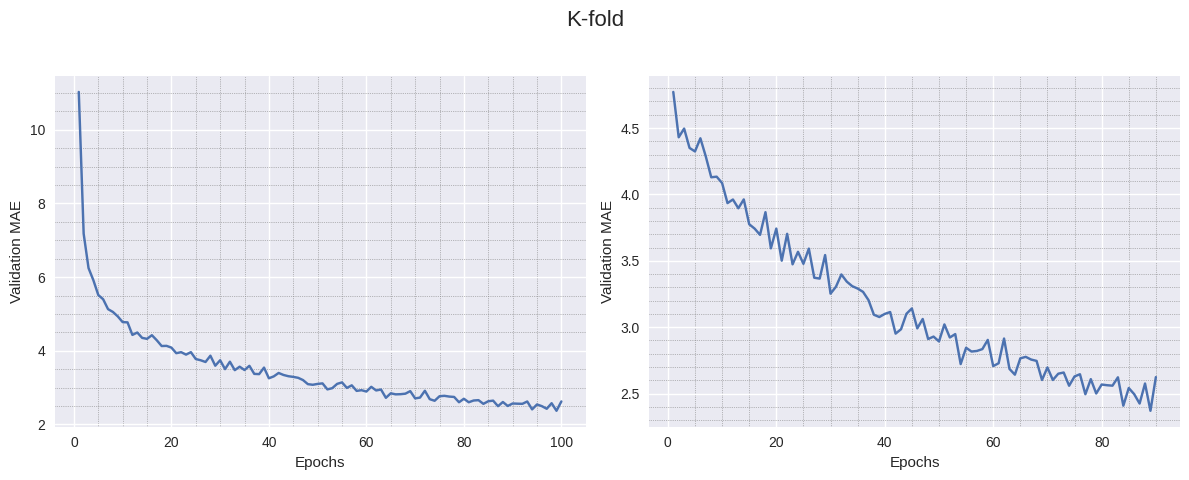

In [31]:
k=4
num_epochs=100
all_scores, all_mae_histories = k_fold_train(k=k, num_epochs=num_epochs)
print("** ",all_scores, all_mae_histories)
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
truncated_mae_history = average_mae_history[10:]

plot_training(average_mae_history, truncated_mae_history)


number of samples in each set will be 101 out of 404 overall
Processing fold #0
Epoch 1/500
19/19 - 1s - 67ms/step - loss: 286.1682 - mae: 12.3178
Epoch 2/500
19/19 - 0s - 3ms/step - loss: 91.1701 - mae: 6.8543
Epoch 3/500
19/19 - 0s - 3ms/step - loss: 78.5202 - mae: 6.3389
Epoch 4/500
19/19 - 0s - 3ms/step - loss: 70.4430 - mae: 6.2091
Epoch 5/500
19/19 - 0s - 3ms/step - loss: 67.6800 - mae: 5.9449
Epoch 6/500
19/19 - 0s - 3ms/step - loss: 59.7947 - mae: 5.5700
Epoch 7/500
19/19 - 0s - 4ms/step - loss: 54.3638 - mae: 5.3488
Epoch 8/500
19/19 - 0s - 3ms/step - loss: 48.4230 - mae: 4.9371
Epoch 9/500
19/19 - 0s - 3ms/step - loss: 42.2479 - mae: 4.6496
Epoch 10/500
19/19 - 0s - 3ms/step - loss: 43.1933 - mae: 4.8618
Epoch 11/500
19/19 - 0s - 3ms/step - loss: 45.5112 - mae: 4.9524
Epoch 12/500
19/19 - 0s - 3ms/step - loss: 37.5181 - mae: 4.4772
Epoch 13/500
19/19 - 0s - 3ms/step - loss: 43.3351 - mae: 4.8030
Epoch 14/500
19/19 - 0s - 3ms/step - loss: 40.0855 - mae: 4.4789
Epoch 15/500
19/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


val_mse=21.15343475341797, val_mae=3.2412073612213135
All Scores =
[2.7253916263580322, 2.7823264598846436, 3.1028387546539307, 3.2412073612213135]
Mean of All Scores = 2.96294105052948
**  [2.7253916263580322, 2.7823264598846436, 3.1028387546539307, 3.2412073612213135] [[12.317846298217773, 6.85430383682251, 6.338887691497803, 6.20913028717041, 5.944876194000244, 5.56997537612915, 5.348818302154541, 4.937053203582764, 4.6496262550354, 4.861802577972412, 4.952435493469238, 4.477152347564697, 4.8029913902282715, 4.478939056396484, 4.256999492645264, 4.388037204742432, 4.155271053314209, 4.5397796630859375, 4.128202438354492, 4.334723472595215, 4.037761211395264, 4.316564559936523, 3.64971661567688, 3.9646785259246826, 4.13614559173584, 4.16584587097168, 4.027411937713623, 4.0882954597473145, 3.977142333984375, 3.9166007041931152, 3.827847480773926, 3.7742207050323486, 3.6669161319732666, 3.6191177368164062, 3.3312835693359375, 3.811121702194214, 3.947301149368286, 3.494068145751953, 3.7

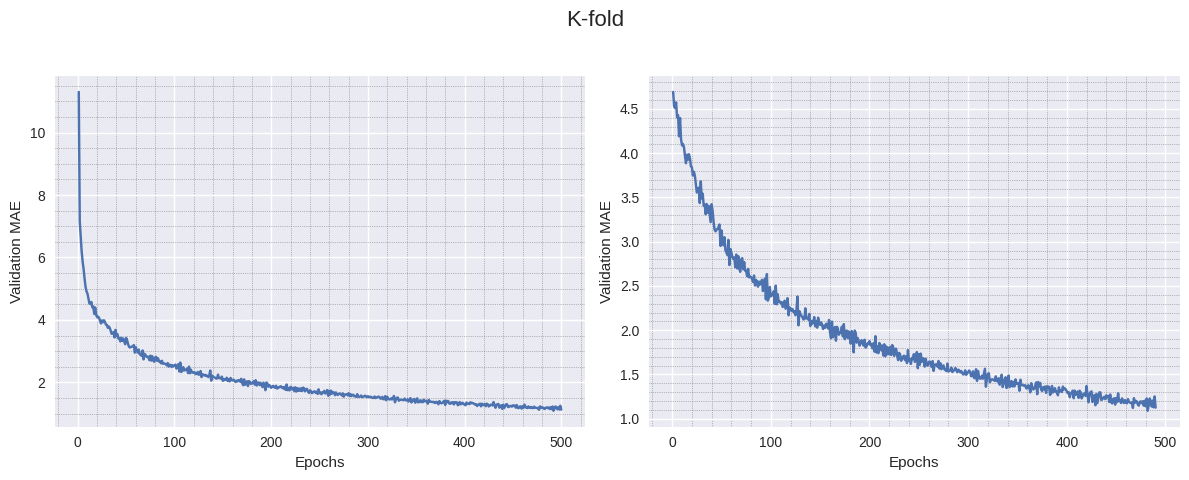

In [32]:
k=4
num_epochs=500
all_scores, all_mae_histories = k_fold_train(k=k, num_epochs=num_epochs)
print("** ",all_scores, all_mae_histories)
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
truncated_mae_history = average_mae_history[10:]

plot_training(average_mae_history, truncated_mae_history)

## Training model for production

Use the same approach but get all data

In [33]:
model = build_model()
model.fit(
    train_data, train_targets, 
    epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 310.5383 - mae: 16.8832  
16.877246856689453


In [45]:
pred_idx = 0

predictions = model.predict(test_data)
print(test_data[pred_idx])
print("""Each of these values represents a standardized feature of the house,
      such as its crime rate,
      the proportion of residential land zoned for lots over 25,000 sq.ft.,
      the concentration of nitric oxides, etc.
      The standardization subtracted the mean and divided by the standard deviation for each feature across all the training data,
      to give them comparable scales.
      """)
print(predictions[pred_idx])
print(f"""Given the model is designed to predict the median value of homes in thousands of dollars,
      this prediction means the model estimates the median value of this particular Boston suburb house
      to be around ${predictions[pred_idx][0]*100000:.0f}""")


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[ 1.55369355 -0.48361547  1.0283258  -0.25683275  1.03838067  0.23545815
  1.11048828 -0.93976936  1.67588577  1.5652875   0.78447637 -3.48459553
  2.25092074]
Each of these values represents a standardized feature of the house,
      such as its crime rate,
      the proportion of residential land zoned for lots over 25,000 sq.ft.,
      the concentration of nitric oxides, etc.
      The standardization subtracted the mean and divided by the standard deviation for each feature across all the training data,
      to give them comparable scales.
      
[0.44620413]
Given the model is designed to predict the median value of homes in thousands of dollars,
      this prediction means the model estimates the median value of this particular Boston suburb house
      to be around $44620
